Projet OC n°3 : Préparez des données pour un organisme de santé publique
========================================================================

III. Exploration, analyse et visualisation des données
******************************************************

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.collections import LineCollection
import missingno as msno
from wordcloud import WordCloud
from ipywidgets import interact
from scipy.stats import normaltest, spearmanr, kruskal
from scipy.interpolate import interp1d
import statsmodels.api as sm
from statsmodels.formula.api import ols
import numpy as np
from sklearn import preprocessing,decomposition

In [2]:
# Chargement des données
data_path = '../Data/cleaned_data.csv'
cleaned_data = pd.read_csv(data_path, delimiter=',', low_memory=False)

In [3]:
# Mapping des types de données pour chaque colonne
cleaned_data = cleaned_data.astype({'additives_n': 'object',
                                    'ingredients_from_palm_oil_n': 'object',
                                    'ingredients_that_may_be_from_palm_oil_n': 'object'})

In [4]:
# Récupération des dimensions du DataFrame
datas = cleaned_data.shape
columns = datas[1]
rows = datas[0]

# Comptage des types de données
data_type = cleaned_data.dtypes.value_counts()
var_qual = data_type.iloc[1]
var_quant = data_type.iloc[0]

# Calcul du nombre total de valeurs
values = cleaned_data.size

# Affichage des informations importantes
print("\033[1m" + "\033[91m" + "Informations importantes :" + "\033[0m" + "\n")
print(f"Total colonnes : {columns} variables.\n")
print(f"    -> {var_qual} variables qualitatives.")
print(f"    -> {var_quant} variables quantitatives.")
print(f"\nTotal lignes : {rows} individus.")
print(f"\nTotal : {values} valeurs.")

Informations importantes :

Total colonnes : 34 variables.

    -> 11 variables qualitatives.
    -> 21 variables quantitatives.

Total lignes : 114058 individus.

Total : 3877972 valeurs.


In [5]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114058 entries, 0 to 114057
Data columns (total 34 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   code                                     114058 non-null  object 
 1   url                                      114058 non-null  object 
 2   creator                                  114058 non-null  object 
 3   created_t                                114058 non-null  int64  
 4   created_datetime                         114058 non-null  object 
 5   last_modified_t                          114058 non-null  int64  
 6   last_modified_datetime                   114058 non-null  object 
 7   product_name                             113907 non-null  object 
 8   brands                                   112720 non-null  object 
 9   brands_tags                              112720 non-null  object 
 10  countries                       

A. Sélection des variables pertinentes pour l'analyse de données et exclusion des variables inutiles : 

In [6]:
# Afficher toutes les colonnes et les lignes
pd.set_option('display.max_column', None)
pd.set_option('display.max_row', None)
cleaned_data.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,brands,brands_tags,countries,countries_tags,countries_fr,ingredients_text,serving_size,additives_n,additives,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutrition_grade_fr,states,states_tags,states_fr,energy_100g,fat_100g,saturated_fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition_score_fr_100g,nutrition_score_uk_100g
0,0000000004559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09 14:32:37,1489069957,2017-03-09 14:32:37,Peanuts,Torn & Glasser,torn-glasser,US,en:united-states,États-Unis,"Peanuts, wheat flour, sugar, rice flour, tapio...",28 g (0.25 cup),0.0,[ peanuts -> en:peanuts ] [ wheat-flour -> ...,0.0,0.0,b,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","A compléter,Informations nutritionnelles compl...",1941.0,17.86,0.00,60.71,17.86,7.1,17.86,0.63500,0.250,0.0,0.0
1,0000000016872,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055650,2017-03-09 10:34:10,1489055651,2017-03-09 10:34:11,Zen Party Mix,Sunridge,sunridge,US,en:united-states,États-Unis,"Roasted peanuts (peanuts, peanut or canola oil...",30 g (0.25 cup),1.0,[ roasted-peanuts -> en:roasted-peanuts ] [...,0.0,0.0,d,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","A compléter,Informations nutritionnelles compl...",2230.0,36.67,5.00,36.67,3.33,6.7,16.67,1.60782,0.633,12.0,12.0
2,0000000018265,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055706,2017-03-09 10:35:06,1489055706,2017-03-09 10:35:06,Energy Power Mix,Sunridge,sunridge,US,en:united-states,États-Unis,"Yogurt raisins, tamari roasted almonds, organi...",40 g (0.25 cup),0.0,[ yogurt-raisins -> en:yogurt-raisins ] [ r...,0.0,0.0,d,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","A compléter,Informations nutritionnelles compl...",1464.0,17.50,7.50,42.50,32.50,5.0,7.50,0.28448,0.112,14.0,14.0
3,0000000018289,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055654,2017-03-09 10:34:14,1489055655,2017-03-09 10:34:15,Antioxidant Mix - Berries & Chocolate,Sunridge,sunridge,US,en:united-states,États-Unis,"Chocolate stars (dehydrated cane juice, sweete...",30 g (0.25 cup),1.0,[ chocolate-stars -> en:chocolate-stars ] [...,0.0,0.0,d,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","A compléter,Informations nutritionnelles compl...",2092.0,33.33,6.67,46.67,30.00,6.7,13.33,0.46482,0.183,15.0,15.0
4,0000000018357,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489138486,2017-03-10 09:34:46,1489138486,2017-03-10 09:34:46,Peanut Butter Power Chews,Sunridge,sunridge,US,en:united-states,États-Unis,"Peanut butter (dry roasted peanuts, palm oil, ...",45 g (45 GRM),3.0,[ peanut-butter -> en:peanut-butter ] [ but...,0.0,0.0,c,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","A compléter,Informations nutritionnelles compl...",1954.0,20.00,2.22,60.00,33.33,4.4,8.89,0.19812,0.078,9.0,9.0


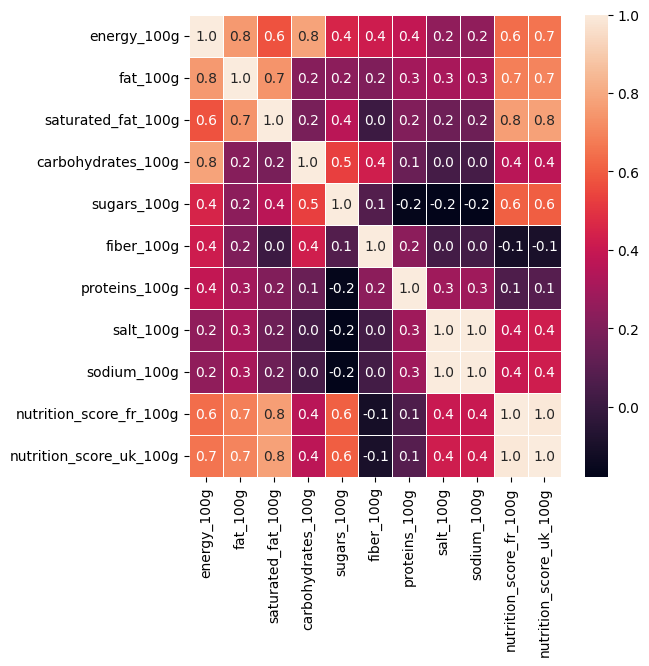

In [7]:
# Sélectionner les colonnes de type float64 dans les données nettoyées
num_columns = cleaned_data.select_dtypes(include=['float64']).columns
num_columns

# Sélectionner les données numériques en utilisant les colonnes sélectionnées précédemment
num_data = cleaned_data[num_columns]

# Tracer la matrice de corrélation des données numériques
f, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(num_data.corr(), annot=True, linewidths=.5, fmt='.1f', ax=ax)
plt.show()

/!\ Attention :  les variables 'salt_100g' et 'sodium_100g' sont deux nutriments similaires & 'nutrition_score_fr_100g' et 'nutrition_score_uk_100g' sont aussi similaires

    - corrélation de 1
--> exclusion de la variable 'sodium_100g' & 'nutrition_score_uk_100g' redondantes

/!\ Attention : le 'nutrition_score_fr_100g' est inversé 

    - corrélation positive au 'salt_100g' (sel), 'satured_fat_100g' (gras saturé) et au 'sugars_100g' (sucre) 
    - corrélation négative au 'fiber_100g' (fibres)    
--> inversion car ici -15 est le meilleur score et 40 le moins bon

--> Variables non pertinentes pour notre analyse :
- 'code'
- 'url'
- 'creator'
- 'last_modified_t'
- 'last_modified_datetime'
- 'ingredients_text'
- 'serving_size'
- 'additives'
- 'states'
- 'states_tags'
- 'states_fr'

--> Variables redondantes :
- 'created_t' & 'created_datetime' -> on garde created_datetime'
- 'brands_tags' & 'brands' -> on garde 'brands'
- 'countries', 'countries_tags' & 'countries_fr' -> on garde 'countries_fr'
- 'nutrition_score_fr_100g' & 'nutrition_score_uk_100g' -> on garde 'nutrition_score_fr_100g'
- 'salt_100g' & 'sodium_100g' -> on garde 'salt_100g'

--> Variables pertinentes pour notre analyse :
- **Date** : 'created_datetime'
- **Informations produit** : 'product_name', 'brands', 'countries_fr', 'category'
- **Additifs / Huile de palme** : 'additives_n', 'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n'
- **Scores de nutrition** : 'nutrition_grade_fr', 'nutrition_score_fr_100g'
- **Energie (pour 100g)** : 'energy_100g'
- **Nutriments (pour 100g)** : 'fat_100g', 'saturated_fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g'

In [8]:
useless_var = ["code", "url", "creator", "created_t", "last_modified_t", "last_modified_datetime", "brands_tags", "countries", "countries_tags", "ingredients_text", "serving_size", "additives", "states", "states_tags", "states_fr", "nutrition_score_uk_100g", "sodium_100g"]

In [9]:
# Supprimer les colonnes inutiles de cleaned_data
cleaned_data.drop(columns=useless_var, inplace=True)

# Inverser les valeurs de la colonne "nutrition_score_fr_100g"
cleaned_data["nutrition_score_fr_100g"] = -cleaned_data["nutrition_score_fr_100g"]

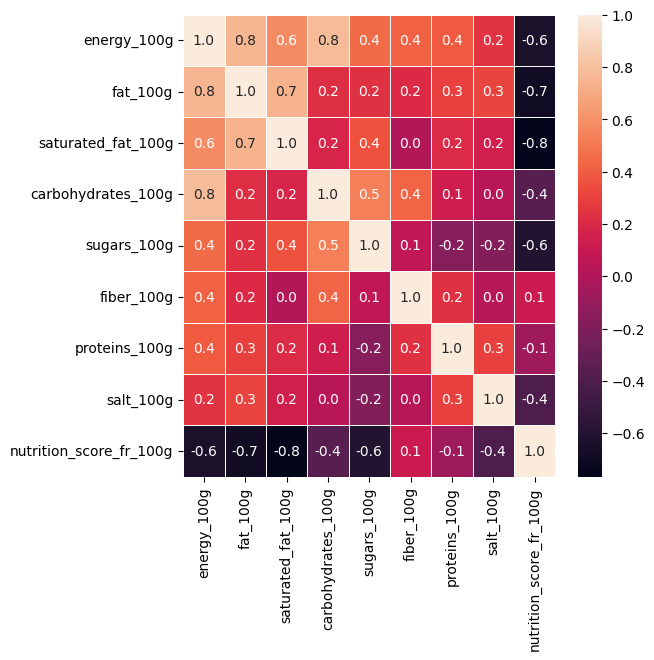

In [10]:
# Sélectionner les colonnes de type float64 dans les données nettoyées
num_columns = cleaned_data.select_dtypes(include=['float64']).columns
num_columns

# Sélectionner les données numériques en utilisant les colonnes sélectionnées précédemment
num_data = cleaned_data[num_columns]

# Tracer la matrice de corrélation des données numériques
f, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(num_data.corr(), annot=True, linewidths=.5, fmt='.1f', ax=ax)
plt.show()

B. Catégorisation des variables pertinentes et analyse des données : 

In [11]:
# Récupération des dimensions du DataFrame
datas = cleaned_data.shape
columns = datas[1]
rows = datas[0]

# Comptage des types de données
data_type = cleaned_data.dtypes.value_counts()
var_qual = data_type.iloc[1]
var_quant = data_type.iloc[0]

# Calcul du nombre total de valeurs
values = cleaned_data.size

# Affichage des informations importantes
print("\033[1m" + "\033[91m" + "Informations importantes :" + "\033[0m" + "\n")
print(f"Total colonnes : {columns} variables.\n")
print(f"    -> {var_qual} variables qualitatives.")
print(f"    -> {var_quant} variables quantitatives.")
print(f"\nTotal lignes : {rows} individus.")
print(f"\nTotal : {values} valeurs.")

Informations importantes :

Total colonnes : 17 variables.

    -> 8 variables qualitatives.
    -> 9 variables quantitatives.

Total lignes : 114058 individus.

Total : 1938986 valeurs.


<Axes: >

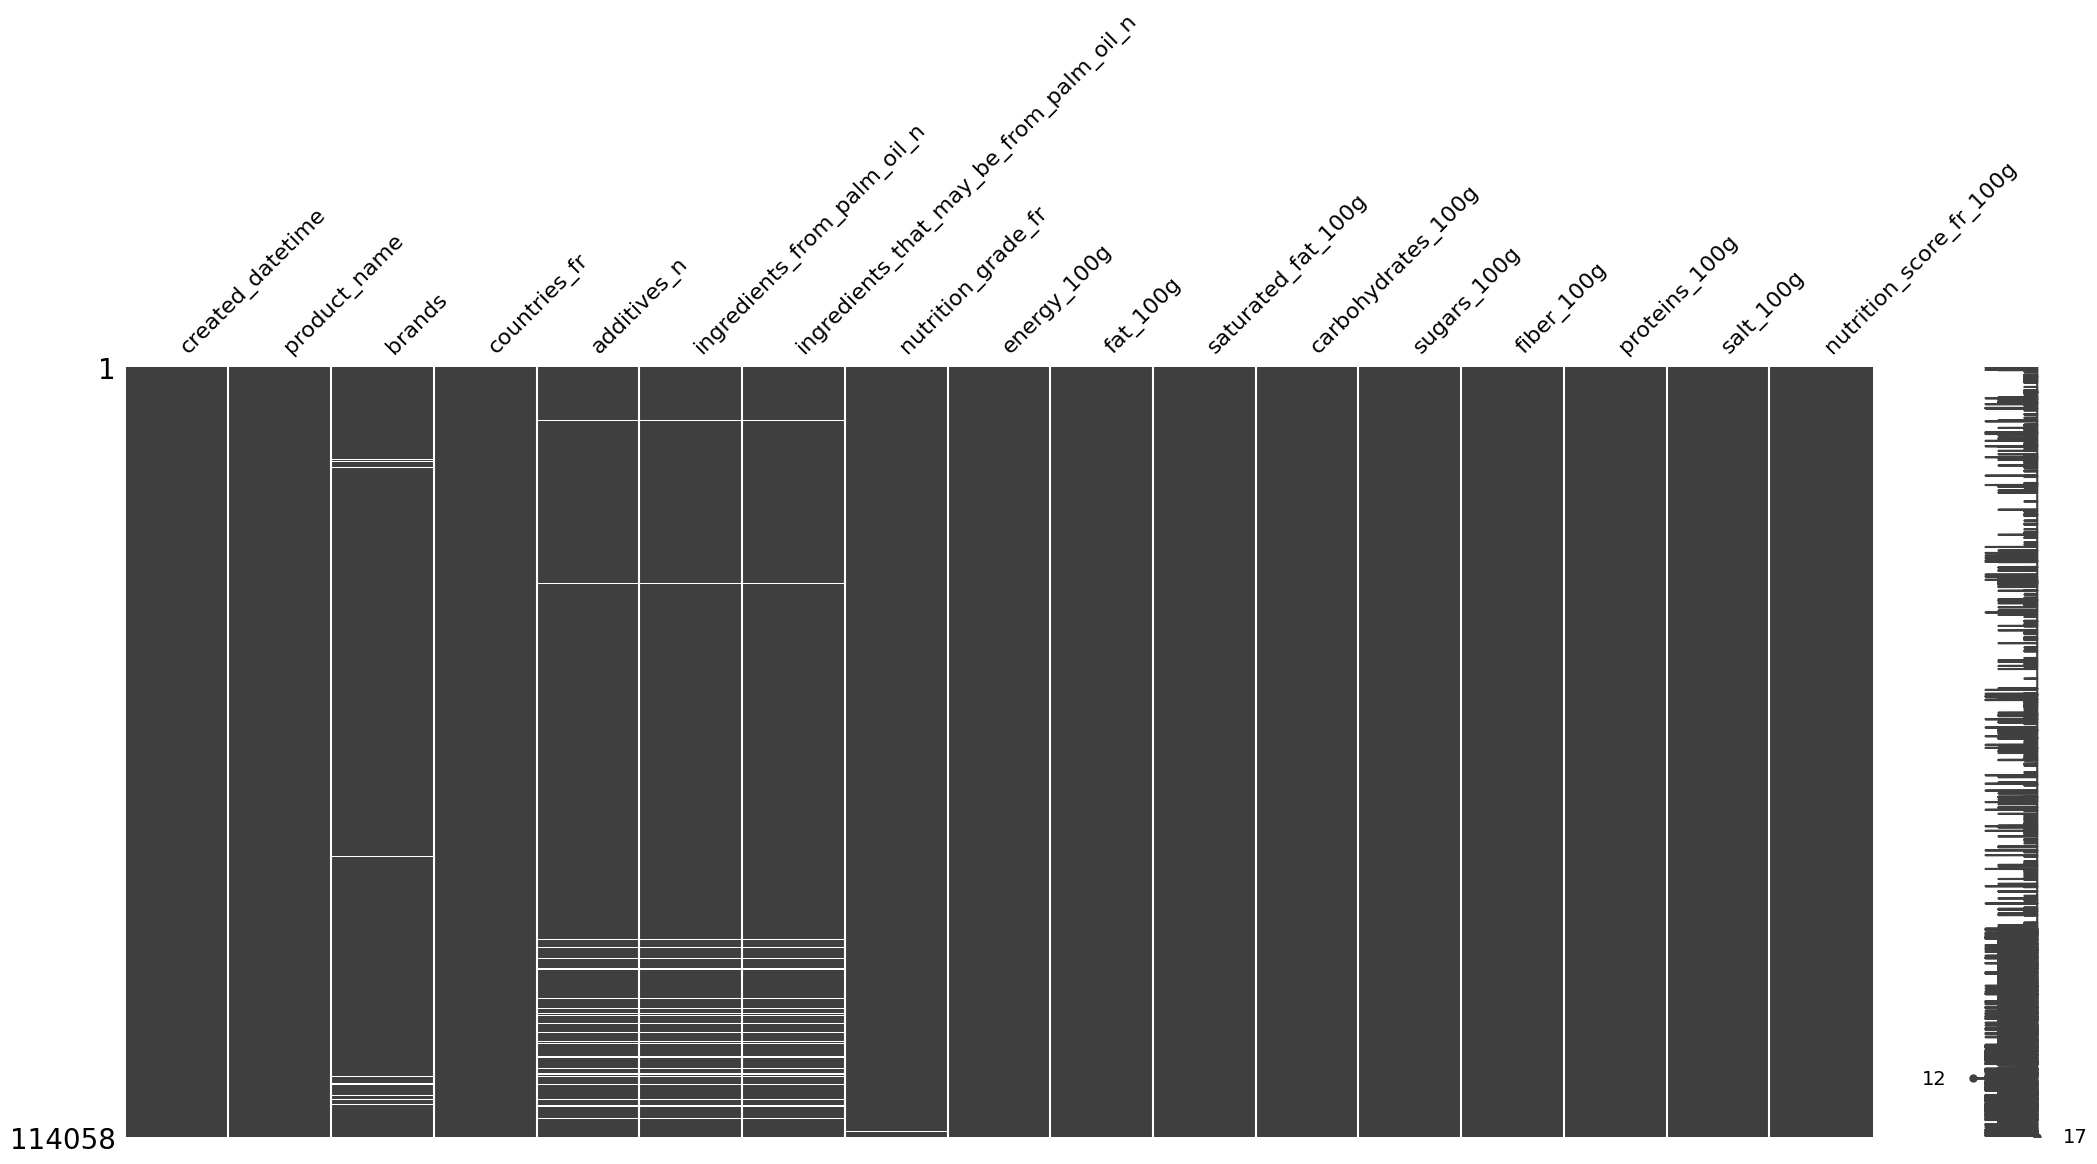

In [12]:
msno.matrix(cleaned_data)

In [13]:
# Catégorisation des variables pour l'analyse
date = ["created_datetime"]
product_infos = ["product_name", "brands", "countries_fr"]
additives = ["additives_n", "ingredients_from_palm_oil_n", "ingredients_that_may_be_from_palm_oil_n"]
nutrigrade = ["nutrition_grade_fr"]
nutriscore = ["nutrition_score_fr_100g"]
energy = ["energy_100g"]
nutriments = ["fat_100g", "saturated_fat_100g", "carbohydrates_100g", "sugars_100g", "fiber_100g", "proteins_100g", "salt_100g"]
var_quant = nutriscore + energy + nutriments
var_qual = product_infos + additives + nutrigrade

    a. Analyse univariée

In [14]:
cleaned_data.describe()

,energy_100g,fat_100g,saturated_fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,nutrition_score_fr_100g
count,114058.000000,114058.000000,114058.000000,114058.000000,114058.000000,114058.000000,114058.000000,114058.000000,114058.000000
mean,989.732720,9.432490,3.040944,31.900794,11.598080,2.052712,6.102126,0.766178,-6.587567
std,686.119486,10.825814,4.061872,26.366376,13.572912,2.129646,5.183049,0.695001,8.461231
min,0.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-36.000000
25%,340.000000,0.740000,0.000000,8.330000,1.750000,0.000000,2.000000,0.127000,-13.000000
50%,909.000000,4.900000,1.100000,22.660000,5.000000,1.500000,5.000000,0.660000,-4.000000
75%,1569.000000,15.790000,4.880000,56.250000,18.600000,3.300000,9.000000,1.191260,-0.000000
max,3515.000000,52.000000,16.670000,100.000000,52.310000,9.000000,21.830000,2.834640,14.000000


### **VISUALISATION INTERACTIVE**

In [15]:
# Définition la fonction pour tracer un boxplot interactif qui prend une colonne comme argument
@interact
def interact_boxplot(col=var_quant):
    plt.figure(figsize=(15, 5))    
    sns.boxplot(x=col, data=cleaned_data, color='#192E90')    
    plt.title("Boxplot pour : " + str(col), fontsize=15)    
    plt.show()

interactive(children=(Dropdown(description='col', options=('nutrition_score_fr_100g', 'energy_100g', 'fat_100g…

In [16]:
# Définition la fonction pour tracer un violinplot interactif qui prend une colonne comme argument
@interact
def interact_violinplot(col=var_quant):
    plt.figure(figsize=(15, 5))
    sns.violinplot(x=col, data=cleaned_data, color='#192E90')
    plt.title("Violinplot pour : " + str(col), fontsize=15)
    plt.show()

interactive(children=(Dropdown(description='col', options=('nutrition_score_fr_100g', 'energy_100g', 'fat_100g…

In [47]:
# Définition la fonction pour tracer un histogramme interactif qui prend une colonne comme argument
@interact
def interact_histogram(col=nutriments):
    plt.figure(figsize=(15, 5))
    plt.hist(cleaned_data[col], color='#192E90', bins=30)
    plt.xlabel("Grammes", fontsize=15)
    plt.ylabel("Nombre de produits", fontsize=15)
    plt.title("Distribution de : " + str(col), fontsize=15)
    plt.show()

interactive(children=(Dropdown(description='col', options=('fat_100g', 'saturated_fat_100g', 'carbohydrates_10…

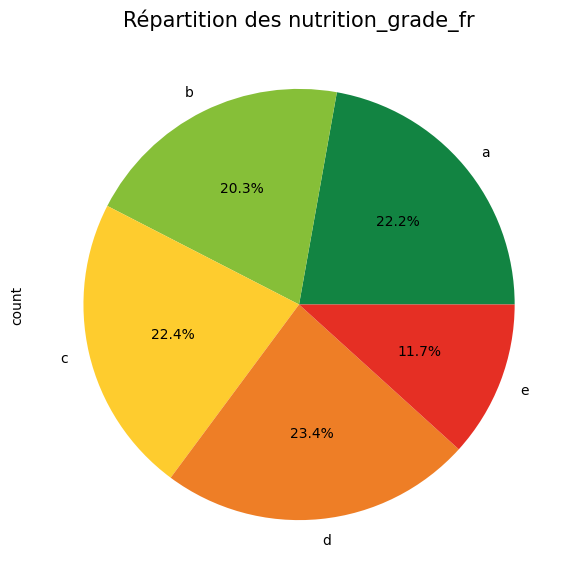

In [18]:
# Créer un diagramme circulaire pour afficher la répartition de la variable nutrigrade
for var in nutrigrade:
    plt.figure(figsize=(10,7))
    plt.title('Répartition des ' + var, fontsize=15)
    cleaned_data[var].value_counts().sort_index().plot.pie(autopct='%1.1f%%', colors = ["#128442", "#86BF38", "#FECC2E", "#EE7E26", "#E52F24"])
    plt.show()

In [19]:
# Créer des diagrammes pour afficher la répartition des variables additifs
@interact
def interactive_barplot(var=additives):
    color1 = '#BE1D58'
    color2 = '#193E90'

    cmap = LinearSegmentedColormap.from_list('custom', [color1, color2])
    value_counts = cleaned_data[var].value_counts()
    plt.figure(figsize=(15,10))
    bars = []
    for i, (value, count) in enumerate(value_counts.items()):
        bar = plt.bar(value, count, color=cmap(i / len(value_counts)))
        bars.append(bar[0])
    plt.title("Nombre de produits pour chaque nombre d' " + var, fontsize=20)
    plt.xlabel(var)
    plt.ylabel("Nombre de produits")
    plt.xticks(rotation=45)
    leg = plt.legend(bars, value_counts.index, loc='upper left', bbox_to_anchor=(1, 1), fontsize='large', title="Légende", title_fontsize='large')
    plt.tight_layout(rect=[0,0,0.85,1])
    plt.show()

interactive(children=(Dropdown(description='var', options=('additives_n', 'ingredients_from_palm_oil_n', 'ingr…

In [20]:
# Créer des nuages de mots pour afficher la répartition des variables d'infos produits
@interact
def interactive_wordcloud(var=product_infos):
    var_occurences = cleaned_data[var].value_counts().to_dict()
    wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(var_occurences)
    plt.figure(figsize=(20,15))
    plt.title("Représentation visuelle du nombre de produits pour chaque " + var, fontsize=20)
    plt.imshow(wordcloud)
    _=plt.axis("off")

interactive(children=(Dropdown(description='var', options=('product_name', 'brands', 'countries_fr'), value='p…

    b. Analyse bivariée

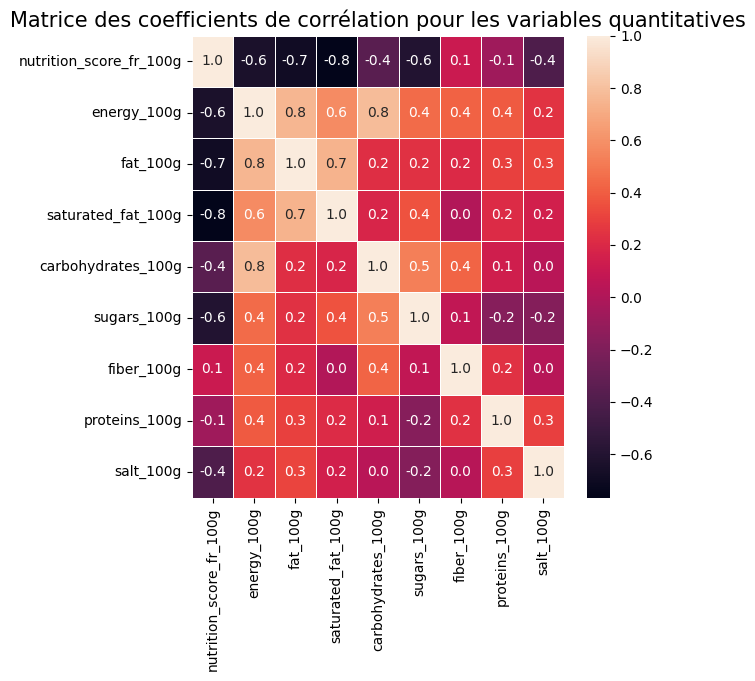

In [21]:
# Tracer la matrice de corrélation des données numériques
num_data = cleaned_data[var_quant]
f, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(num_data.corr(), annot=True, linewidths=.5, fmt='.1f', ax=ax)
plt.title("Matrice des coefficients de corrélation pour les variables quantitatives", fontsize=15)
plt.show()

--> Variables avec hautes intensité de corrélation :

- Corrélation positive (coefficient de corrélation > 0.7) :
    - 'energy_100g' & 'fat_100g'
    - 'energy_100g' & 'carbohydrates_100g'
    - 'fat_100g' & 'saturated_fat_100g'
    
- Corrélation négative (coefficient de corrélation < -0.7) :
    - 'nutrition_score_fr_100g' & 'fat_100g'
    - 'nutrition_score_fr_100g' & 'saturated_fat_100g'

In [22]:
data_correls = cleaned_data.dropna()

--> Test de normalité des variables : Seuil fixé à **5%**

- Hypothèse nulle **H0** : La variable suit une distribution normale.
    - on peut utiliser un test paramétrique (test de Pearson).

- Hypothèse alternative **H1** : La variable ne suit pas une distribution normale.
    - on doit utiliser un test non-paramétrique (test de Spearman).

In [23]:
var_to_test = ['energy_100g', 'fat_100g', 'carbohydrates_100g', 'saturated_fat_100g', 'nutrition_score_fr_100g']

In [24]:
# Effectuer le test de normalité
for var in var_to_test:
    print("Test de normalité de la variable :", var)
    stat, p = normaltest(data_correls[var])
    print(f"Valeur_p = {p:.3f}")
    if p > 0.05:
        print("--> On ne peux pas rejeter H0 : La variable est distribuée selon une loi normale à un seuil de 5%")
    else:
        print("--> On peut rejetter H0 : La variable n'est pas distribuée selon une loi normale à un seuil de 5%")
    print()

Test de normalité de la variable : energy_100g
Valeur_p = 0.000
--> On peut rejetter H0 : La variable n'est pas distribuée selon une loi normale à un seuil de 5%

Test de normalité de la variable : fat_100g
Valeur_p = 0.000
--> On peut rejetter H0 : La variable n'est pas distribuée selon une loi normale à un seuil de 5%

Test de normalité de la variable : carbohydrates_100g
Valeur_p = 0.000
--> On peut rejetter H0 : La variable n'est pas distribuée selon une loi normale à un seuil de 5%

Test de normalité de la variable : saturated_fat_100g
Valeur_p = 0.000
--> On peut rejetter H0 : La variable n'est pas distribuée selon une loi normale à un seuil de 5%

Test de normalité de la variable : nutrition_score_fr_100g
Valeur_p = 0.000
--> On peut rejetter H0 : La variable n'est pas distribuée selon une loi normale à un seuil de 5%



--> Aucunes variables n'est distribuées selon une loi normale à un seuil de **5%**

- Hypothèse alternative **H1** : La variable ne suit pas une distribution normale.
    - on doit utiliser un test non-paramétrique : test de Spearman ( : Seuil fixé à **5%**)
        - Hypothèse nulle **H0** : les 2 variables sont **indépendantes**
        - Hypothèse alternative **H1** : les 2 variables sont **liées**

In [25]:
var_to_test = [('energy_100g', 'fat_100g'),
               ('energy_100g', 'carbohydrates_100g'),
               ('fat_100g', 'saturated_fat_100g'),
               ('nutrition_score_fr_100g', 'fat_100g'),
               ('nutrition_score_fr_100g', 'saturated_fat_100g')]

In [26]:
# Pour chaque paire de variables dans var_to_test calculer la corrélation de Spearman et la valeur p
for var in var_to_test:
    print("Test de significativité de la corrélation positive entre : ", var[0], "et", var[1])
    correl, p = spearmanr(data_correls[var[0]], data_correls[var[1]])
    print(f"Valeur_p = {p:.3f}")
    
    if p > 0.05:
        print("-> On ne peut pas rejeter H0 : La corrélation positive n'est pas statistiquement significative à un seuil de 5%")
    else:
        print("-> On peut rejeter H0 : La corrélation positive est statistiquement significative à un seuil de 5%")

    print()

Test de significativité de la corrélation positive entre :  energy_100g et fat_100g
Valeur_p = 0.000
-> On peut rejeter H0 : La corrélation positive est statistiquement significative à un seuil de 5%

Test de significativité de la corrélation positive entre :  energy_100g et carbohydrates_100g
Valeur_p = 0.000
-> On peut rejeter H0 : La corrélation positive est statistiquement significative à un seuil de 5%

Test de significativité de la corrélation positive entre :  fat_100g et saturated_fat_100g
Valeur_p = 0.000
-> On peut rejeter H0 : La corrélation positive est statistiquement significative à un seuil de 5%

Test de significativité de la corrélation positive entre :  nutrition_score_fr_100g et fat_100g
Valeur_p = 0.000
-> On peut rejeter H0 : La corrélation positive est statistiquement significative à un seuil de 5%

Test de significativité de la corrélation positive entre :  nutrition_score_fr_100g et saturated_fat_100g
Valeur_p = 0.000
-> On peut rejeter H0 : La corrélation posit

--> Les coefficients de corrélation étudiés sont statistiquement significatifs avec un niveau de risque fixé à **5%**

- Hypothèse alternative **H1** : La variable ne suit pas une distribution normale.
    - on doit utiliser un test non-paramétrique : test de Spearman ( : Seuil fixé à **5%**)
        - Hypothèse alternative **H1** : les 2 variables sont **liées**

### **VISUALISATION INTERACTIVE**

In [27]:
# Définir la fonction pour tracer un joinplot interactif qui prend deux variables quantitatives comme arguments
@interact
def interact_jointplot(var0=var_quant, var1=var_quant):
    g=sns.jointplot(x=var0, y=var1, data=cleaned_data, kind='reg', color='#193E90')
    plt.title(f"Distributions croisé --> entre {var0} et {var1}", fontsize=25)
    g.fig.set_figwidth(15)
    g.fig.set_figheight(15)
    plt.show()

interactive(children=(Dropdown(description='var0', options=('nutrition_score_fr_100g', 'energy_100g', 'fat_100…

In [28]:
nutriscore_palette = ["#128442", "#86BF38", "#FECC2E", "#EE7E26", "#E52F24"]
sns.set(palette=nutriscore_palette)

In [29]:
# Définir la fonction pour tracer un nuage de points qui prend deux variables quantitatives comme arguments
@interact
def interact_scatterplot(var0=var_quant, var1=var_quant):
    plt.figure(figsize=(15,15))
    sns.scatterplot(x=var0, y=var1, data=cleaned_data, hue="nutrition_grade_fr", hue_order=["a", "b", "c", "d", "e"])
    plt.title(f"Diagramme de dispersion --> relation entre {var0}, {var1} et le nutriscore", fontsize=15)
    plt.show()

interactive(children=(Dropdown(description='var0', options=('nutrition_score_fr_100g', 'energy_100g', 'fat_100…

In [30]:
# Définir la fonction pour tracer un countplot interactif qui prend une variable catégorielle (additives) comme argument
@interact
def interact_histocount(var=additives):
    plt.figure(figsize=(15,15))
    sns.countplot(data=cleaned_data, x="nutrition_grade_fr", hue=var, order=["a","b","c","d","e"])
    plt.title(f"Effectifs des produits pour chaque {var} par nutriscore", fontsize=25)
    plt.show()

interactive(children=(Dropdown(description='var', options=('additives_n', 'ingredients_from_palm_oil_n', 'ingr…

In [31]:
# Définir la fonction pour tracer des boxplots interactifs en fonction du nutrigrade et qui prend une variable quantitative comme argument
@interact
def interact_boxplot(var=var_quant):
    plt.figure(figsize=(10,10))
    sns.boxplot(x="nutrition_grade_fr", y=var, data=cleaned_data, hue="nutrition_grade_fr", hue_order=["a", "b", "c", "d", "e"], order=["a", "b", "c", "d", "e"])
    plt.title(f"Visualisation de la variables quantitative {var} en fonction du nutriscore", fontsize=25)
    plt.show()

interactive(children=(Dropdown(description='var', options=('nutrition_score_fr_100g', 'energy_100g', 'fat_100g…

In [32]:
# Définir la fonction pour tracer des boxplot interactifs qui prennent une variable d'additif et une variable de nutriment comme arguments
@interact
def interact_boxplot(additive=additives, nutriment=nutriments):
    plt.figure(figsize=(15,10))
    sns.boxplot(x=additive, y=nutriment, data=cleaned_data, color='#193E90')
    plt.title(f"Visualisation de la variable de nutriment -> {nutriment} en fonction de la variable d'additif -> {additive}", fontsize=15)
    plt.show()

interactive(children=(Dropdown(description='additive', options=('additives_n', 'ingredients_from_palm_oil_n', …

--> Analyse de la variance (ANOVA)


In [33]:
# Définition des listes de variables quantitatives et qualitatives
var_qual = additives + nutrigrade + ['countries_fr']
var_quant = var_quant

# Fonction pour calculer le rapport de corrélation (eta carré) pour une paire de variables
def calculate_eta_sq(var_quanti, var_quali, data):
    model = ols(f'{var_quanti} ~ C({var_quali})', data=data).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    sum_sq_between = anova_table.iloc[0]['sum_sq']  # Somme des carrés inter-classes
    sum_sq_total = sum(anova_table['sum_sq'])  # Somme totale des carrés
    eta_sq = sum_sq_between / sum_sq_total  # Coefficient de détermination (eta carré)
    return eta_sq

# Construction de la matrice de Rapports de corrélation entre les variables = matrice de variance expliquée
mat_eta_sq = np.zeros((len(var_qual), len(var_quant)))  # Initialisation de la matrice

for i, var_quanti in enumerate(var_quant):
    for j, var_quali in enumerate(var_qual):
        mat_eta_sq[j, i] = calculate_eta_sq(var_quanti, var_quali, cleaned_data)

# Construction du DataFrame correspondant
df_anova = pd.DataFrame(mat_eta_sq, index=var_qual, columns=var_quant)
df_anova.head()

,nutrition_score_fr_100g,energy_100g,fat_100g,saturated_fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g
additives_n,0.114262,0.034209,0.015093,0.042219,0.038287,0.066985,0.022077,0.002550,0.040168
ingredients_from_palm_oil_n,0.014416,0.014344,0.007694,0.022634,0.009224,0.008539,0.003373,0.000115,0.000036
ingredients_that_may_be_from_palm_oil_n,0.006939,0.002716,0.002185,0.009006,0.001386,0.002827,0.000752,0.000605,0.000137
nutrition_grade_fr,0.931191,0.397368,0.433401,0.578319,0.139141,0.338556,0.065409,0.041809,0.165957
countries_fr,0.019478,0.008546,0.006978,0.005434,0.008796,0.009696,0.008056,0.003752,0.014207


In [34]:
# Définir la fonction pour afficher le résultat de l'ANOVA interactif
@interact
def interactive_anova(var_quanti=var_quant, var_quali=var_qual):
    eta_sq = calculate_eta_sq(var_quanti, var_quali, cleaned_data)
    print(f"\nRapport de Corrélation = {eta_sq:.2f}")
    print(f"-> Les variables {var_quanti} et {var_quali} sont liées à hauteur de {eta_sq:.2f}")
    print(f"-> La variance de la variable {var_quanti} est expliquée à {eta_sq:.2f} par la variable {var_quali}")

interactive(children=(Dropdown(description='var_quanti', options=('nutrition_score_fr_100g', 'energy_100g', 'f…

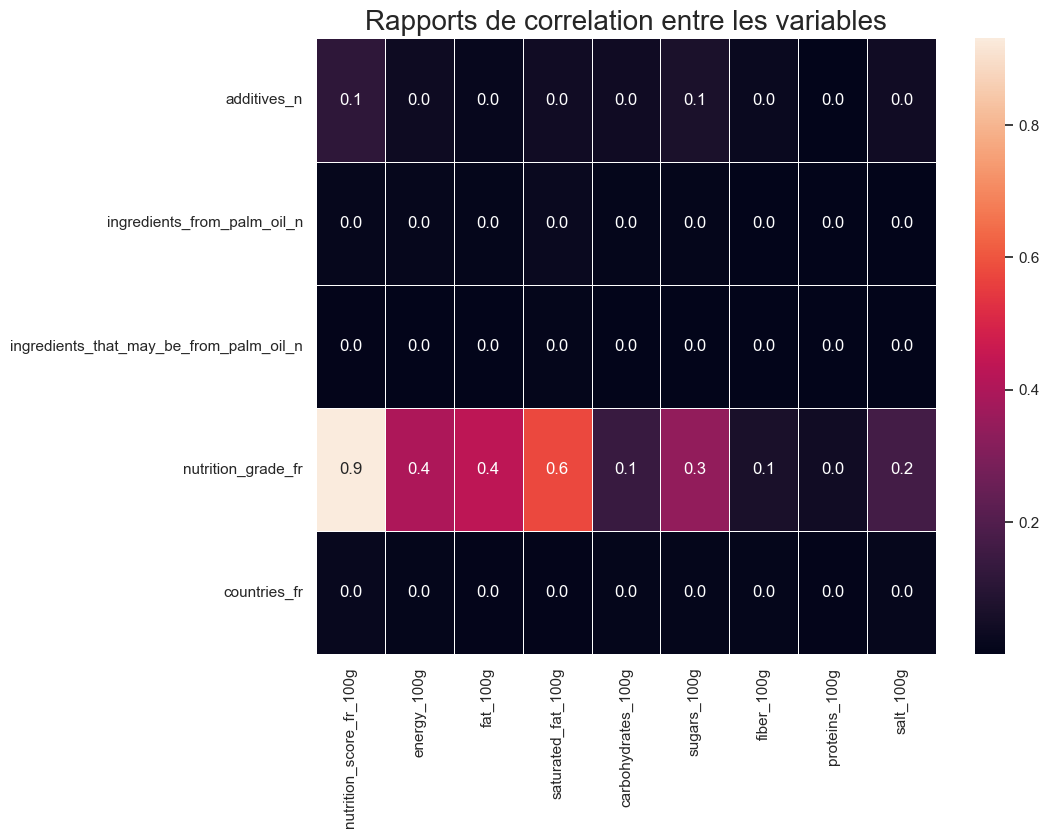

In [35]:
# Tracer la matrice de corrélation entre les variables quantitatives et qualitatives
f,ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df_anova, annot=True, linewidths=.5, fmt= '.01f',ax=ax)
plt.title("Rapports de correlation entre les variables", fontsize=20)
plt.show()

--> Les variables suivantes semblent être liées (rapports de corrélation > 0.6) :
- 'nutrition_score_fr_100g' et 'nutrition_grade_fr'
- 'nutrition_grade_fr' et 'saturated_fat_100g'

In [36]:
# Effectuer le test de Kruskal-Wallis pour eprouver la significativité des liaison entre les variables
def perform_kruskal_test(data, category_column, category_values, variable_column):
    lists = [data[data[category_column] == val][variable_column] for val in category_values]
    coeff_det, p = kruskal(*lists)
    print(f"Test statistique de la significativité de la liaison entre la variable {category_column} et la variable {variable_column}")
    print(f"Valeur_p = {p:.3f}")
    if p > 0.05:
        print("-> On ne peut pas rejeter H0 : La liaison entre les 2 variables n'est pas statistiquement significative à un seuil de 5%")
    else:
        print("-> On peut rejeter H0 : La liaison entre les 2 variables est statistiquement significative à un seuil de 5%")

# Test pour nutrition_score_fr_100g
perform_kruskal_test(cleaned_data, 'nutrition_grade_fr', ['a', 'b', 'c', 'd', 'e'], 'nutrition_score_fr_100g')
print()
# Test pour saturated_fat_100g
perform_kruskal_test(cleaned_data, 'nutrition_grade_fr', ['a', 'b', 'c', 'd', 'e'], 'saturated_fat_100g')


Test statistique de la significativité de la liaison entre la variable nutrition_grade_fr et la variable nutrition_score_fr_100g
Valeur_p = 0.000
-> On peut rejeter H0 : La liaison entre les 2 variables est statistiquement significative à un seuil de 5%

Test statistique de la significativité de la liaison entre la variable nutrition_grade_fr et la variable saturated_fat_100g
Valeur_p = 0.000
-> On peut rejeter H0 : La liaison entre les 2 variables est statistiquement significative à un seuil de 5%


--> Les rapports de corrélation étudiés sont statistiquement significatifs avec un risque de première espèce fixé à 5%

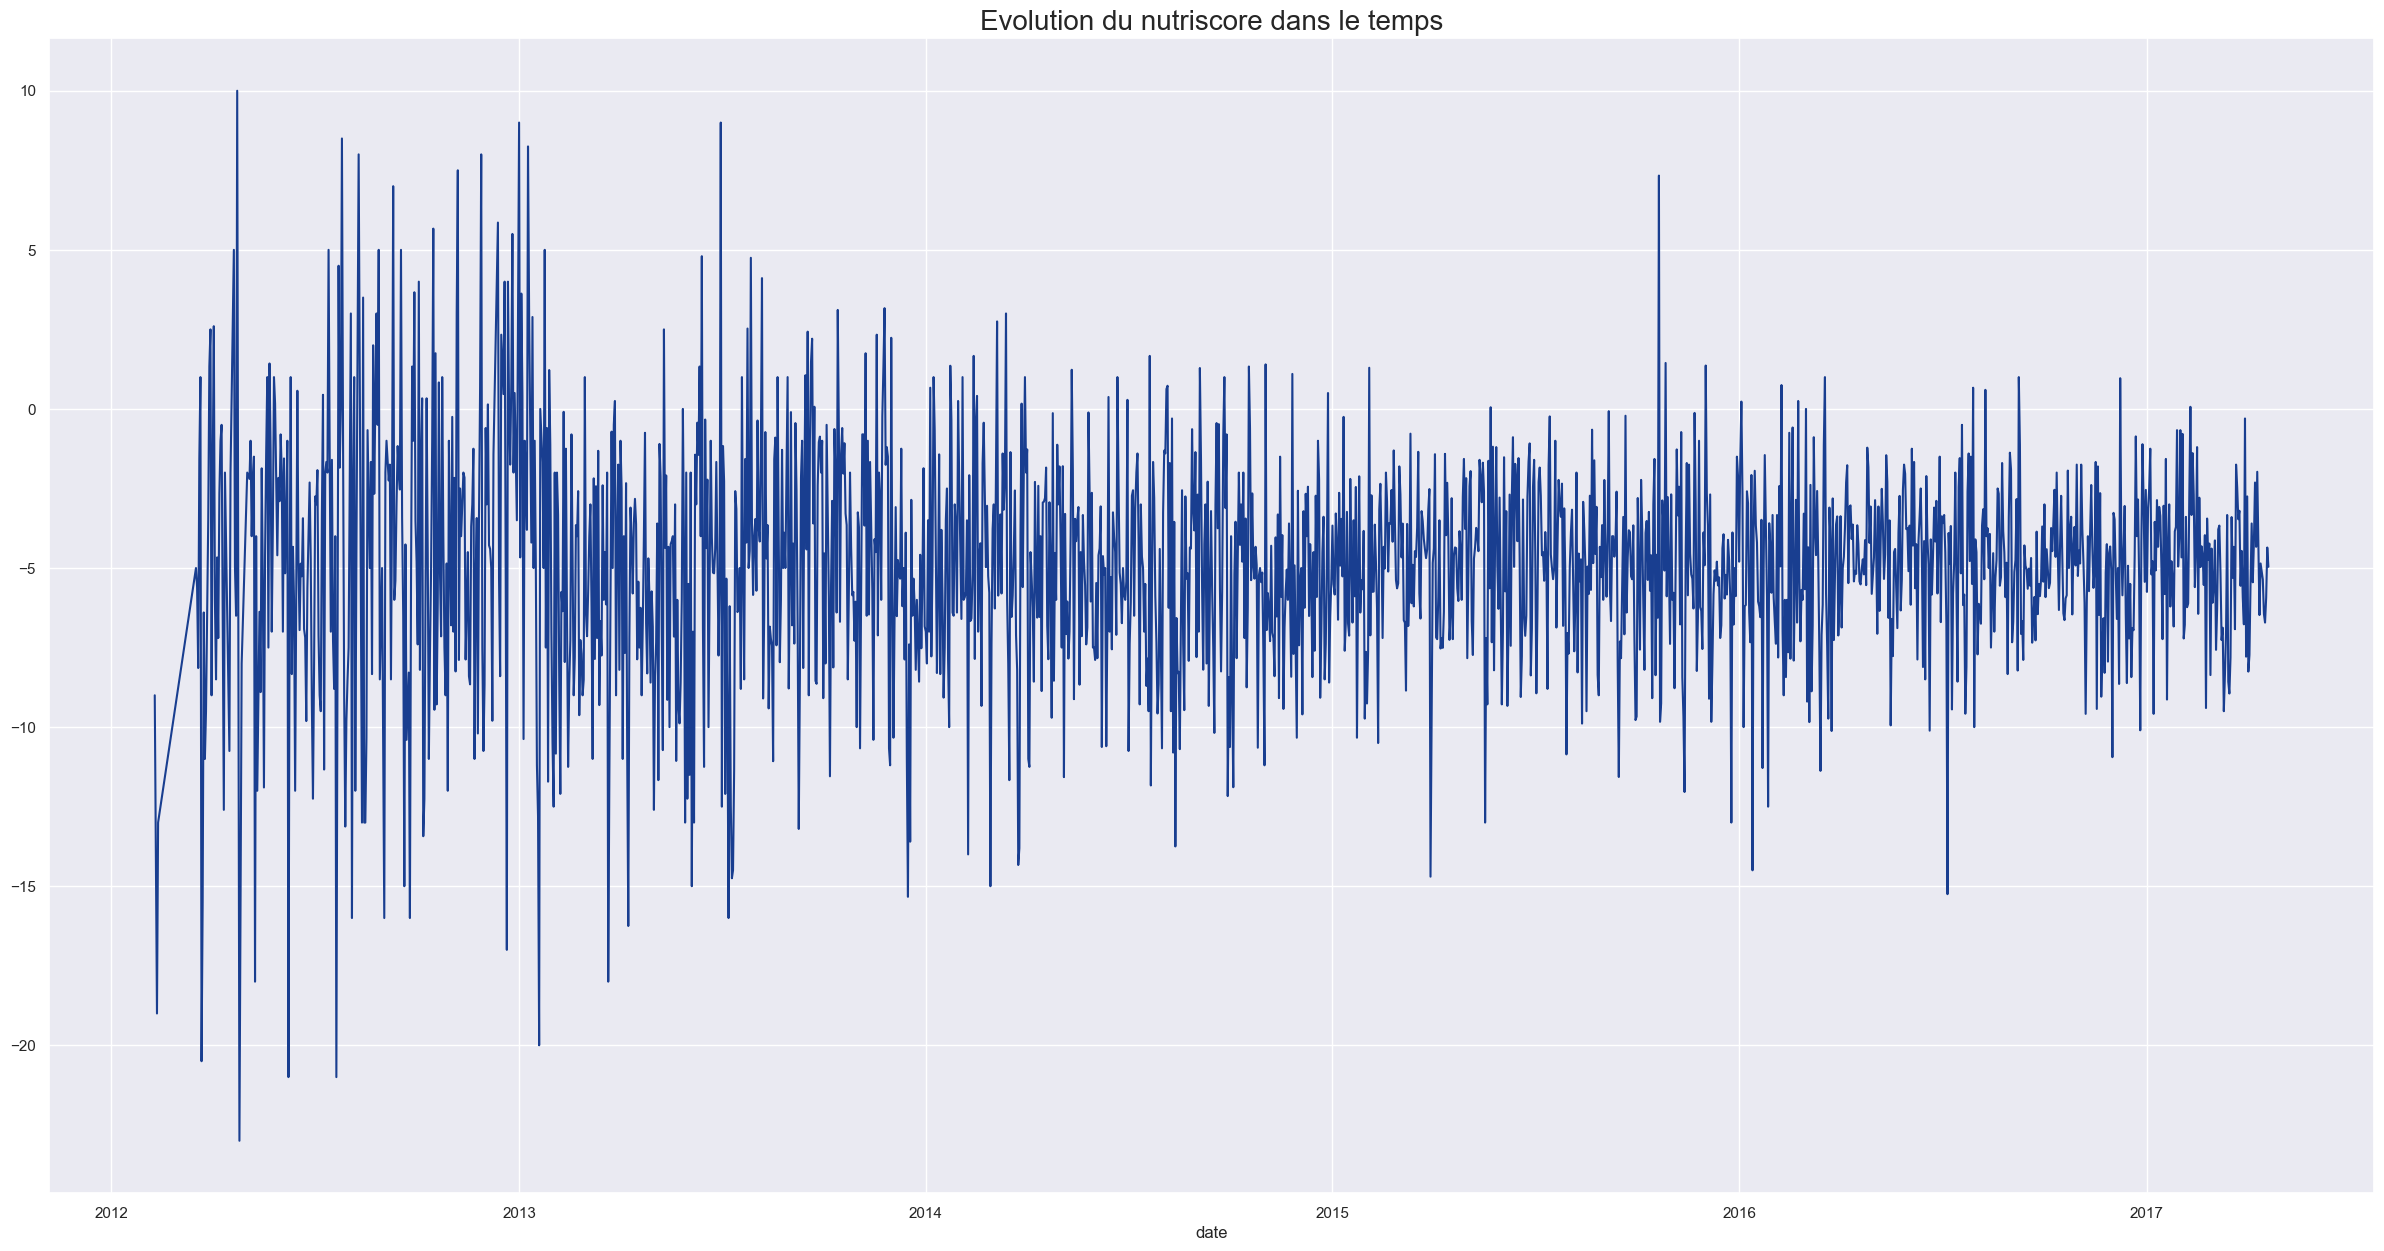

In [37]:
# Calculer la moyenne du nutriscore pour chaque date et tracer l'évolution moyenne du nutriscore dans le temps
cleaned_data = cleaned_data.astype({'created_datetime': 'datetime64[ns]'})
cleaned_data["date"] = cleaned_data["created_datetime"].dt.date
plt.figure(figsize=(30,15))
cleaned_data.groupby("date")["nutrition_score_fr_100g"].mean().plot(color='#193E90')
plt.title("Evolution du nutriscore dans le temps", fontsize=20)
plt.show()

    c. Analyse multivariée --> Analyse en Composantes Principales (PCA)

In [38]:
df_object_columns = cleaned_data.select_dtypes(include=['object']) 
cleaned_data[df_object_columns.columns] = df_object_columns.astype('category')

In [39]:
def display_scree_plot(pca, scale_factor=1):
    fig_size = [7,6]
    fig_size = list(np.array(fig_size) * scale_factor)
    plt.rcParams['figure.figsize'] = fig_size
    
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)


def display_factorial_plane(X_projected, n_comp, pca, axis_ranks, df, alpha=1, scale_factor=1):
    fig_size = [7,6]
    fig_size = list(np.array(fig_size) * scale_factor)
    
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=fig_size)
        
            # affichage des points
            legend_column = 'additives_n'
            legend_title = 'nb additives'
            scatter = plt.scatter(X_projected[:, d1], 
                                  X_projected[:, d2], 
                                  c=df[legend_column].astype('category').cat.codes, 
                                  alpha=alpha)
            plt.legend(handles=scatter.legend_elements()[0], 
                       labels=range(df['additives_n'].shape[0]),
                       title=legend_title)
            
            # détermination des limites du graphique
            
            #old boundary:
            #boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            
            quantile = 0.99
            margin = 2
            boundary = np.quantile(np.abs(X_projected[:, [d1,d2]]), quantile) * margin
            
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes avec le pourcentage d'inertie
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)


def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None, scale_factor=1):
    fig_size = [7,6]
    fig_size = list(np.array(fig_size) * scale_factor)

    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=fig_size)

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

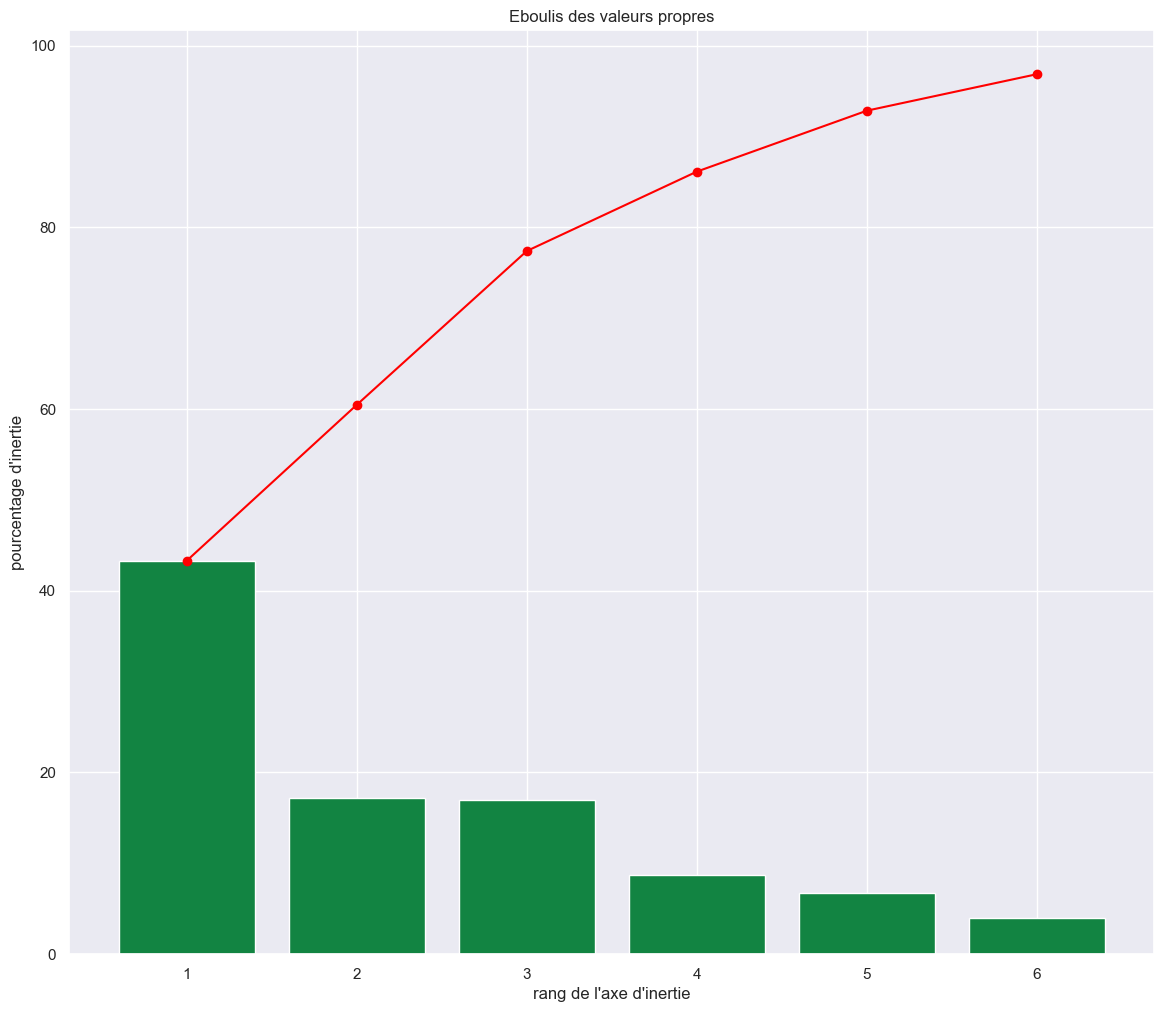

In [40]:
nb_comp = 6
scale_factor = 2


data_pca = cleaned_data[var_quant]
names = data_pca.index
features = data_pca.columns

# convert to numpy array
X = data_pca.values

# normalize
std_scale = preprocessing.StandardScaler().fit(X)
X = std_scale.transform(X)

# PCA
pca = decomposition.PCA(n_components=nb_comp)
pca.fit(X)

# éboulis
display_scree_plot(pca, scale_factor=scale_factor)

In [41]:
# Affichage interactif des Cercles des corrélations
@interact
def interactive_correlation_circles(nb_axes=[2, 4, 6]):
    print("Liaison entre les variables / Synthétisation des variables :")
    pcs = pca.components_
    axis_ranks = [(i, i+1) for i in range(0, nb_axes, 2)]
    display_circles(pcs, nb_comp, pca, axis_ranks, labels=np.array(features))

interactive(children=(Dropdown(description='nb_axes', options=(2, 4, 6), value=2), Output()), _dom_classes=('w…

In [42]:
# Affichage interactif de la Projection des individus
@interact
def interactive_factorial_planes(nb_axes=[2, 4, 6]):
    print("Profils des produits :")
    X_projected = pca.transform(X)
    if nb_axes==2:
        display_factorial_plane(X_projected, nb_comp, pca, [(0,1)], cleaned_data)
    elif nb_axes==4:
        display_factorial_plane(X_projected, nb_comp, pca, [(0,1),(2,3)], cleaned_data)
    else:
        display_factorial_plane(X_projected, nb_comp, pca, [(0,1),(2,3),(4,5)], cleaned_data)

interactive(children=(Dropdown(description='nb_axes', options=(2, 4, 6), value=2), Output()), _dom_classes=('w…

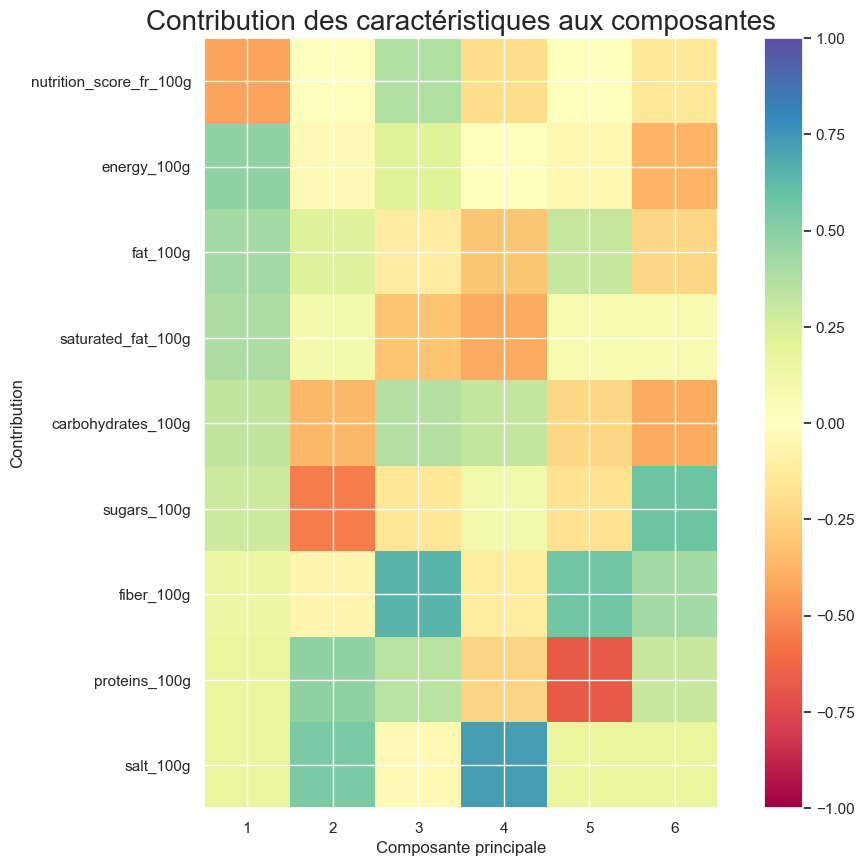

In [43]:
fig, ax = plt.subplots(figsize=(12,10))
plt.imshow(pca.components_.T,
           cmap='Spectral',
           vmin=-1,
           vmax=1)
plt.yticks(range(len(data_pca.columns)), data_pca.columns)
plt.xticks(range(6), range(1,7))
plt.xlabel("Composante principale")
plt.ylabel("Contribution")
plt.title("Contribution des caractéristiques aux composantes", fontsize=20)
plt.colorbar()
plt.show()

### Interprétation des deux premiers axes factoriels :
#### Axe F1 : 
- tous les nutriments et l'énergie sont positivement corrélés à la variable F1. La corrélation la plus élevée est avec l'énergie et ensuite le gras
- le nutriscore est négativement corrélé à la variable F1
#### -> on peut interpréter l'axe F1 comme représentant la valeur énérgétique

#### Axe F2 :
- les variables ayant les corrélations positives les plus élevées avec à la variable F2 sont les fibres et les protéines, 2 nutriments qui sont bons pour la santé
- le nutriscore est également positivement corrélé à la variable F2
- les variables ayant les corrélations négatives les plus élevées (en valeur absolue) avec la variable F2 sont le gras saturé et le sucre, 2 nutriments qui sont mauvais pour la santé
#### -> on peut interpréter l'axe F2 comme représentant les bénéfices sur la santé

#### On retrouve cette interprétation sur le graphique de la projection des individus sur les axes factoriels F1 et F2